# MAXIMUM MEAN DISCREPANCY (MMD) IN MACHINE LEARNING


Maximum mean discrepancy (MMD) is a kernel based statistical test used to determine whether given two distribution are the same which is proposed in [[1]](#references). MMD can be used as a loss/cost function in various machine learning algorithms such as density estimation, generative models as shown in [[2]](#references), [[3]](#references) and also in invertible neural networks utilized in inverse problems as in [[4]](#references). As opposed to generative adversarial networks (GANs) which require a solution to a complex min-max optimization problem, MMD criteria can be used as simpler discriminator. 

Main advantages are easy implementation and rich kernel based theory behind the idea that lends itself to a formal analysis. On the other hand, disadvantages are subjectively "mediocre" sample results compared to GANs as reported in [[2]](#references), [[3]](#references) and the same computational cost overheads regarding kernel based methods when the feature size of the data is reasonable large.  

**Notation:**
- Random variables are denotes with capital $X$.
- Vectors are column matrices.
- Vectors are denoted with roman bold type $\mathbf{x}$.
- Probability distribution of expected values are not shown explicitly unless unclear from context.

**Note:** Reader who is not interested in formal mathematical derivations can skip to [Implementation of MMD](#implementation_of_mmd) section.


## Formal Definition

Maximum mean discrepancy (MMD) can be defined in two different ways which are equivalent to each other:

1. *MMD* is a distance (difference) between *feature means*.
2. *MMD* is an integral probability metric (which will not be covered in this post. Please refer to [[1]](#references)).

Let's start with the concepts used in definition of feature means. Firstly given an $X$, a feature map $\phi$ maps $X$ to an another space $\mathcal{F}$ such that $\phi(X) \in \mathcal{F}$. Assuming $\mathcal{F}$ satisfies the necessary conditions, we can benefit from the kernel trick to compute the inner product in $\mathcal{F}$:

$$ X, Y \text{ such that} ~~ k(X, Y) = \langle \phi(X), \phi(Y) \rangle_{\mathcal{F}} $$

**1. Feature means:** Given a probability measure $P$ on $\mathcal{X}$, feature means (or mean embedding as sometimes called in the literature) is an another feature map that takes $\phi(X)$ and maps it to the means of every coordinate of $\phi(X)$:

$$ \mu_{p} ~ (\phi(X)) = \left[ E[\phi(X_{1}], \cdots , E[\phi(X_{m}] \right]^{T} \tag{1} $$ 

Inner product of feature means of $X \sim P$ and $Y \sim Q$ can be written in terms of kernel function such that:

$$ \langle \mu_{P}~(\phi(X), \mu_{Q}~(\phi(Y) \rangle_{\mathcal{F}} = E_{P,Q}~ [\langle \phi(X), \phi(Y) \rangle_{\mathcal{F}}] = E_{P,Q}~ [k(X,Y)] \tag{2}$$

**2. Maximum mean discrepancy:** Given $X,Y$ maximum mean discrepancy is the distance between feature means of $X,Y$:

$$ MMD^{2}(P,Q) = \Vert \mu_{P} - \mu_{Q} \Vert^{2} _{\mathcal{F}} \tag{3} $$ 

For convenience we have left out the $\phi(\cdot)$ parts. If we use the norm induced by the inner product such that $\Vert x \Vert = \sqrt{\langle x, x \rangle}$, the equation (3) becomes

$$ MMD^{2}(P,Q) = \langle \mu_{P} - \mu_{Q}, ~ \mu_{P} - \mu_{Q} \rangle = \langle \mu_{P}, \mu_{P} \rangle -2 \langle \mu_{P}, \mu_{Q} \rangle + \langle \mu_{Q}, \mu_{Q} \rangle $$

Using the equation (2), finally above expression becomes

$$ MMD^{2}(P,Q) = E_{P}~ [k(X,X)] - 2 E_{P,Q}~ [k(X,Y)] + E_{Q}~ [k(Y,Y)] \tag{4} $$

We will use the equation (4) in the derivation of empirical estimate of the MMD.

- **Remark:** The term maximum in maximum mean discrepancy comes from the second definition of MMD which is an integral probability metric including a supremum. This definition utilize a supremum and a function belonging to a unit ball $F$ in Reproducing Kernel Hilbert Space. We are only giving the formal definition and remind the reader that both definition are equivalent. For further information please refer to [[1]](#references)

$$ MMD(P, Q; \mathcal{F}) = \underset{\Vert f \Vert \leq 1}{sup~} E_{X} [f(X)] - E_{Y} [f(Y)] $$

**3. Empirical estimation of MMD:** Even though we are working with distributions so far, in real life settings we don't have access to the underlying distribution of our data. For this reason, it is possible to use an estimate for the equation (4) with following formula:


$$ MMD^{2}(X,Y) = \underbrace{\frac{1}{m (m-1)} \sum_{i} \sum_{j \neq i} k(\mathbf{x_{i}}, \mathbf{x_{j}})}_\text{A} - \underbrace{2 \frac{1}{m.m} \sum_{i} \sum_{j} k(\mathbf{x_{i}}, \mathbf{y_{j}})}_\text{B} + \underbrace{\frac{1}{m (m-1)} \sum_{i} \sum_{j \neq i} k(\mathbf{y_{i}}, \mathbf{y_{j}})}_\text{C} \tag{5} $$

One interpretation of the equation (5) is that $\mathbf{x_{i}}$'s are the data points we already have and $\mathbf{y_{i}}$'s are the generated examples so that MMD score guides us towards the evaluation of underlying distributions. In the next section, we will demonstrate how to implement the equation (5) in pytorch and use the MMD as a training criteria in generative models such that our distribution model doesn't diverge from the given data.

## Implementation of MMD

In this section, we code the equation (5) in pytorch. This implementation benefits greatly from the pytorch forum discussion in [here](https://discuss.pytorch.org/t/maximum-mean-discrepancy-mmd-and-radial-basis-function-rbf/1875). In addition to MMD, curious reader can find custom loss function implementations using pytoch in [here](https://discuss.pytorch.org/t/build-your-own-loss-function-in-pytorch/235). Main idea behind the code is first obtaining the similarity matrices between  $X$ and $X$, $X$ and $Y$, finally $Y$ and $Y$ with given distance metric, then plugging the results to kernel specific function such as exponential. 

For example, let's say kernel in question is gaussian meaning 

$$ k(\mathbf{x_{i}}, \mathbf{x_{j}}) = \exp \left(\frac{- \Vert \mathbf{x_{i}} - \mathbf{x_{j}} \Vert^{2}}{2\sigma^{2}}\right) = \exp \left(\frac{-1}{\sigma^{2}} [\mathbf{x_{i}}^\intercal \mathbf{x_{i}} - 2 \mathbf{x_{i}}^\intercal \mathbf{x_{j}} + \mathbf{x_{j}}^\intercal \mathbf{x_{j}}]\right) $$

If we can construct a matrix with elements such that for every i and j corresponding element is $[\mathbf{x_{i}}^\intercal \mathbf{x_{i}} - 2 \mathbf{x_{i}}^\intercal \mathbf{x_{j}} + \mathbf{x_{j}}^\intercal \mathbf{x_{j}}]$, then it is possible to just plug that matrix into `pytorch.exp()` for the result.

In [0]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

## Code practice

In this section, we compare two multivariate gaussian distribution with different mean and covariance

MMD result of X and Y is 0.39560213685035706


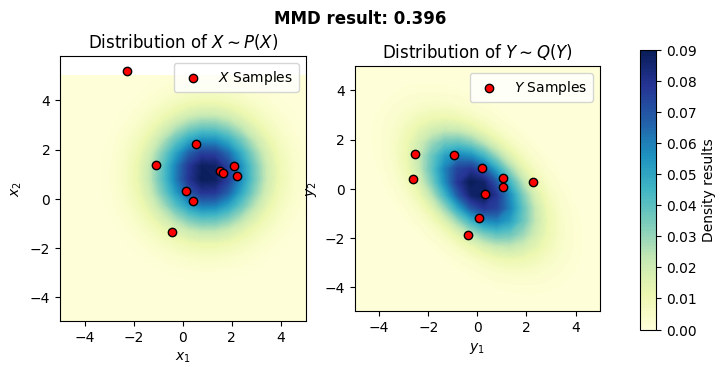

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 


m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout() 
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title("Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title("Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()


## Implementation of "Training Generative Neural Networks via Maximum Mean Discrepancy [[2]](#references)"

Paper specifications of setting and neural network used in the experimental results:

- Dataset is MNIST.
- Input size is not specified in the paper, so chosen size in this example is 32. Output size is the same as the dimension of MNIST dateset instances.
- 3 fully connected hidden layers with the size of 1000, 600 and 1000. Preferred activation function is RELU.
- Batch size is 500.
- Optimizer is RMSprop.
- Kernel function is radial basis function.

Observations:

- In the paper, an extensive hyperparameter search is conducted so kernel choice, learning rate etc. in this example is arbitrary and decided purely based on exemplary reasons.
- Since no hyperparameter tunning is performed, multiscale kernel is found to be more successful than gaussian kernel contrary to the paper. In fact, when kernel type is chosen as `"rbf"`, a clear mode collapse occurs. 

In [32]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

root = "/"
BATCH_SIZE = 500
N_INP = 32
N_OUT = 784
N_GEN_EPOCHS = 1
KERNEL_TYPE = "multiscale"

# Class definition Generative with Maximum Mean Discrepancy (GMMD)
class GMMD(nn.Module):
    def __init__(self, n_start, n_out):
        super(GMMD, self).__init__()
        self.fc1 = nn.Linear(n_start, 1000)
        self.fc2 = nn.Linear(1000, 600)
        self.fc3 = nn.Linear(600, 1000)
        self.fc4 = nn.Linear(1000, n_out)

    def forward(self, samples):
        x = F.sigmoid(self.fc1(samples))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataloader
trans = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=BATCH_SIZE,
        shuffle=True)

# define the GMMD

gmmd_net = GMMD(N_INP, N_OUT).to(device)

try:
  gmmd_net.load_state_dict(torch.load("gmmd.pth"))
  print("Model parameters are loaded")
  
except:
  pass

gmmd_optimizer = optim.RMSprop(gmmd_net.parameters(), lr=0.003)

def train_one_step(x, samples):
    samples = Variable(samples).to(device)
    gen_samples = gmmd_net(samples)

    loss = MMD(x, gen_samples, KERNEL_TYPE)
    gmmd_optimizer.zero_grad()
    loss.backward()
    gmmd_optimizer.step()

    return loss
  
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

Model parameters are loaded


In [0]:
# training loop
iterations = 0
Z = torch.randn((120,BATCH_SIZE, N_INP))
for ep in range(N_GEN_EPOCHS):
    avg_loss = 0
    resampling_limit = 300 # From paper
    
    for idx, (x, _) in enumerate(train_loader):
        iterations += 1
        x = x.view(x.size()[0], -1)
        x = Variable(x).to(device)
        
        # normal random noise between [0, 1]
        random_noise = Z[idx,:,:]

        loss = train_one_step(x, random_noise)
        avg_loss += loss.item()
    
        if iterations % 300 == 0:
           Z = random_noise = torch.randn((120,BATCH_SIZE, N_INP))     
       
           
    avg_loss /= (idx + 1)
    print(f"GMMD Training: {ep}. epoch completed, average loss: {avg_loss}")

torch.save(gmmd_net.state_dict(), "gmmd.pth")

After training, we can sample from the model and visualize them so that it is possible to inspect the quality of generated instances. Following code draws 32 sampes.

Images generated by GMMD


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


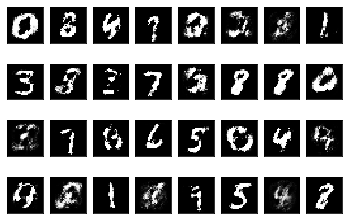

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

Z = random_noise = torch.randn((120,BATCH_SIZE, N_INP))
trans = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)
view_data = [test_set[i][0] for i in range(4 * 8)]
plt.gray()

print("Images generated by GMMD")

for r in range(4):
  for c in range(8):
    ax = plt.subplot(4, 8, r * 8 + c + 1)

    noise = torch.randn((1, N_INP)).to(device)
    y = gmmd_net(noise)
    plt.imshow(y.detach().squeeze().cpu().reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# References

[[1]]() Arthur Gretton, Karsten M Borgwardt, Malte J Rasch, Bernhard Schölkopf, and Alexander Smola. A kernel two-sample test. *Journal of Machine Learning Research*, 13(Mar):723–773, 2012.

[[2]]() Gintare Karolina Dziugaite, Daniel M Roy, and Zoubin Ghahramani. Training generative neural
networks via maximum mean discrepancy optimization. *arXiv preprint arXiv:1505.03906*, 2015.

[[3]]() Yujia Li, Kevin Swersky, and Richard Zemel. Generative moment matching networks. *arXiv
preprint arXiv:1502.02761*, 2015

[[4]]() Lynton Ardizzone, Jakob Kruse, Sebastian Wirkert, Daniel Rahner, Eric W Pellegrini, Ralf S
Klessen, Lena Maier-Hein, Carsten Rother, and Ullrich Kothe. Analyzing inverse problems with invertible neural networks. *arXiv preprint arXiv:1808.04730*, 2018.